# Previsão de Demanda de Táxi em Aeroportos para Otimização do Atendimento

A empresa Taxi Corrida Maluca coletou dados históricos sobre pedidos de táxi nos aeroportos. Para atrair mais motoristas durante o horário de pico, precisamos prever a quantidade de pedidos de táxi para a próxima hora.

A métrica REQM no conjunto de teste não deve ser superior a 48.

# Sumário
1. [Iniciação](#1)
2. [Análise](#2)
3. [Treinamento de Modelos](#3)
  - [Linear Regression](#31)
  - [Decision Tree](#32)
  - [Random Forest](#33)
  - [CatBoost](#34)
  - [LightGBM](#35)
4. [Conclusão](#4)

# Iniciação <a name='1'></a>

Importando as bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
random_state=12345

Suprimindo avisos e evitando a interrupção do fluxo de execução

In [2]:
import sys
import warnings
if not sys.warnoptions:
       warnings.simplefilter("ignore")

In [3]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Não há valores ausentes. Agora verificaremos se há duplicatas verificando quantos valores exclusivos estão presentes no índice de data e hora:

In [5]:
data.index.unique().shape

(26496,)

Não há duplicatas. Verificando se o tipo de dado do índice é `date`.

In [6]:
data.index.is_all_dates

True

Inferimos que os dados estão com os tipos de dados corretos.

# Análise <a name='2'></a>

Analisaremos tendências e sazonalidade em diferentes prazos. Primeiro, plotaremos o número de pedidos após a reamostragem por hora.

<AxesSubplot:xlabel='datetime'>

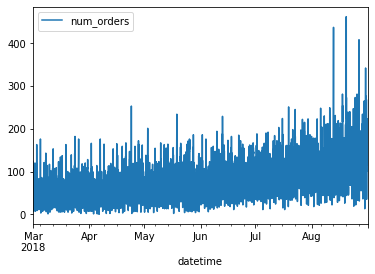

In [7]:
data.sort_index(inplace=True)
data_h = data.resample('1H').sum()
data_h.plot()

Para uma melhor visualização decomporemos os dados em sazonalidade, tendência e resíduos para em seguida plotá-los.

Text(0.5, 1.0, 'Resíduos')

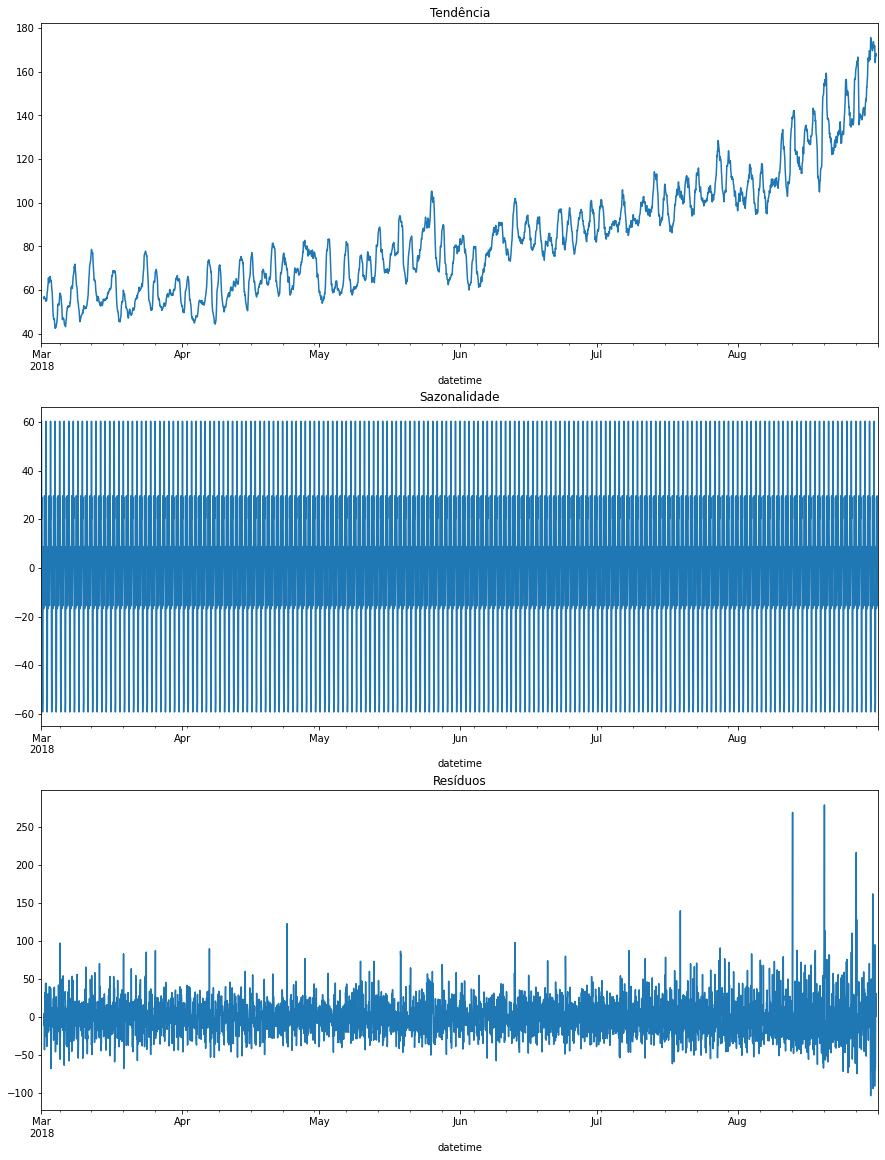

In [8]:
decomposed = seasonal_decompose(data_h)

plt.figure(figsize=(15, 20))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')

Ao longo dos meses, observamos um aumento consistente ou uma tendência positiva. No entanto, não conseguimos identificar nenhum padrão sazonal nesse período. Para detectar picos ou mínimos incomuns, analisamos os resíduos, embora eles ainda representem uma quantidade significativa de pontos. Para uma melhor análise, reamostraremos os dados horários para dados diários, adicionando a média móvel e o desvio padrão móvel, e em seguida, plotaremos os resultados.

<AxesSubplot:xlabel='datetime'>

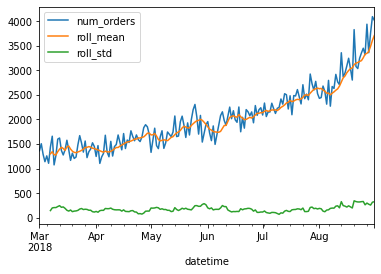

In [9]:
data_day = data_h.resample('1D').sum()
data_day['roll_mean'] = data_day['num_orders'].rolling(7).mean()
data_day['roll_std'] = data_day['num_orders'].rolling(7).std()
data_day.plot()

Durante todo o período observado, notamos um aumento constante na média e uma estabilidade significativa no desvio padrão. Agora, analisaremos os dados por hora, focando na fatia `semanal`, a fim de identificar possíveis tendências e sazonalidades. Para essa análise, foi selecionado o intervalo de 9 a 15 de abril, abrangendo de segunda-feira a domingo.

Text(0.5, 1.0, 'Resíduos')

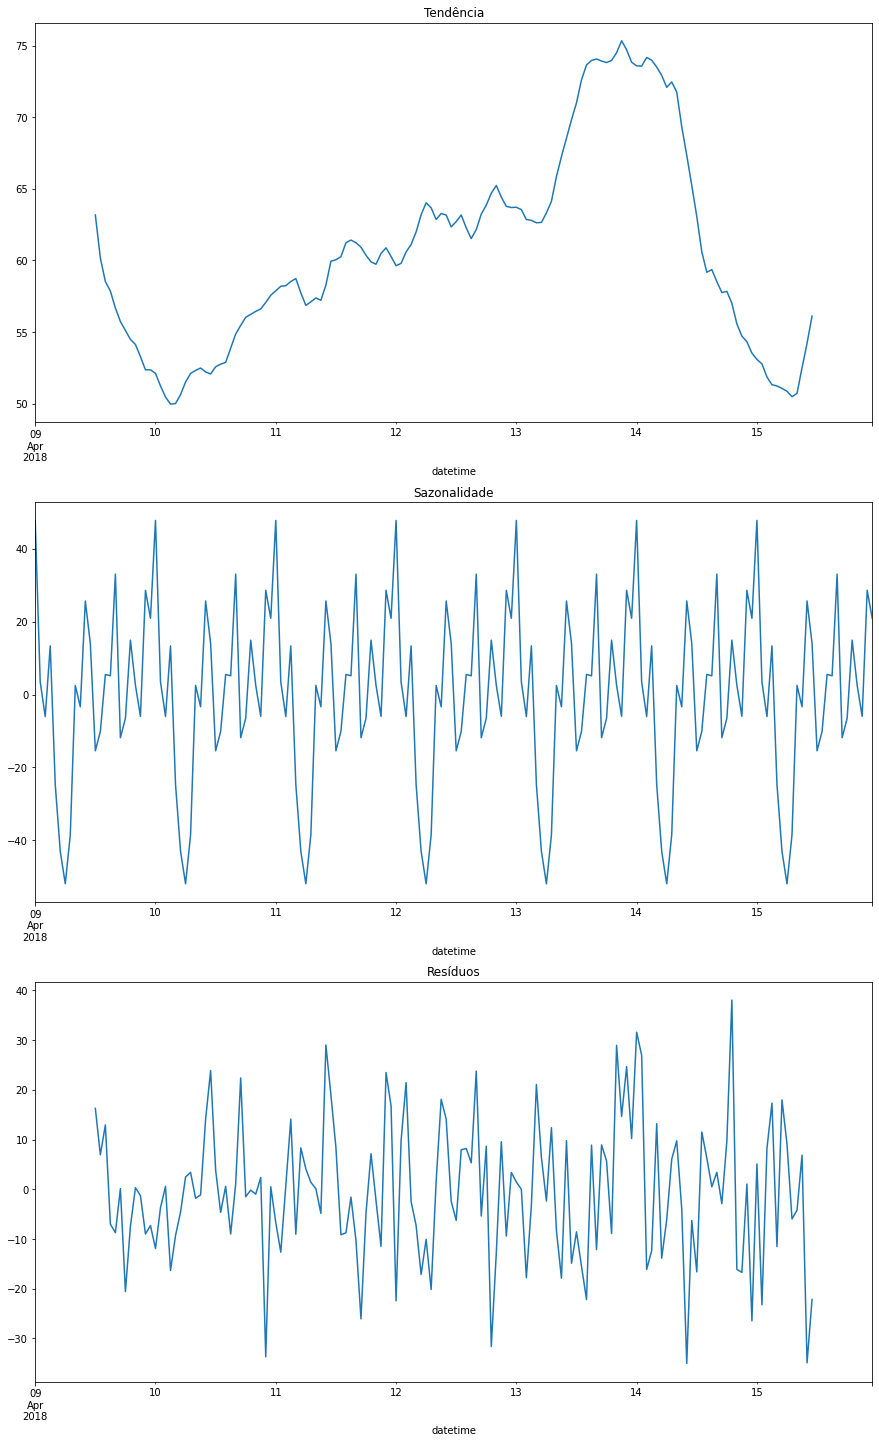

In [10]:
decomposed = seasonal_decompose(data_h.loc['2018-04-09':'2018-04-15',:])

plt.figure(figsize=(15, 25))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')

Ao analisar a tendência, fica evidente que o maior volume de pedidos ocorreu no dia 14, que foi um sábado. Ao observar o gráfico de sazonalidade, podemos identificar um padrão consistente ao longo do dia: há uma queda de pedidos entre meia-noite e aproximadamente 06:00, seguida de um aumento gradual. Ao longo do dia, são observados vários picos, sendo o mais alto por volta das 23h.
Ao analisar os resíduos, notamos a ocorrência de picos nos pedidos, sendo o mais alto registrado durante a noite de sábado. Para uma visualização mais completa, plotaremos os dados juntamente com a média móvel e o desvio padrão móvel.

<AxesSubplot:xlabel='datetime'>

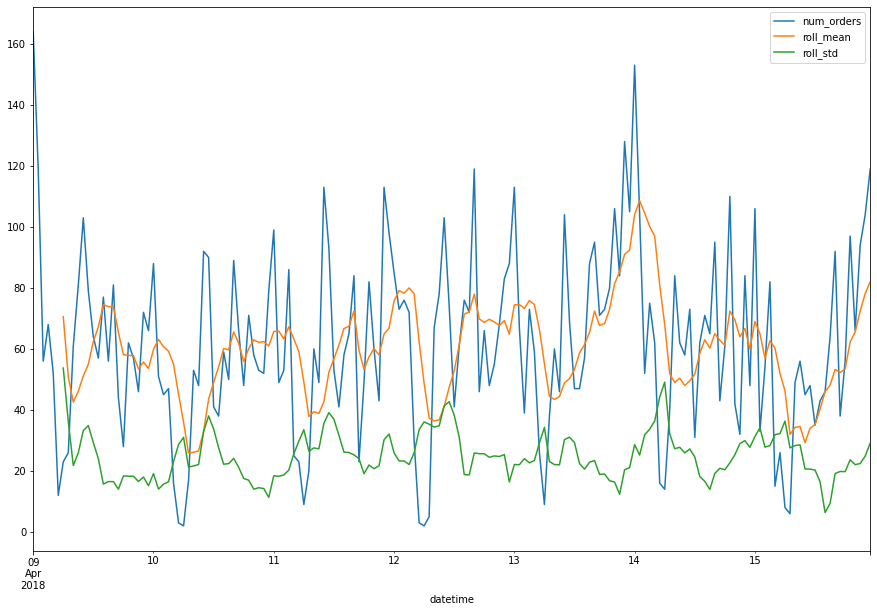

In [11]:
data_spec_w = data_h.loc['2018-04-09':'2018-04-15',:]
data_spec_w['roll_mean'] = data_spec_w['num_orders'].rolling(7).mean()
data_spec_w['roll_std'] = data_spec_w['num_orders'].rolling(7).std()
data_spec_w.plot(figsize=(15, 10))

O sábado teve a média e o desvio padrão mais altos. Agora avaliaremos a tendência para um período de 1 dia. Iremos examinar o dia 30 de agosto.

Text(0.5, 1.0, 'Resíduos')

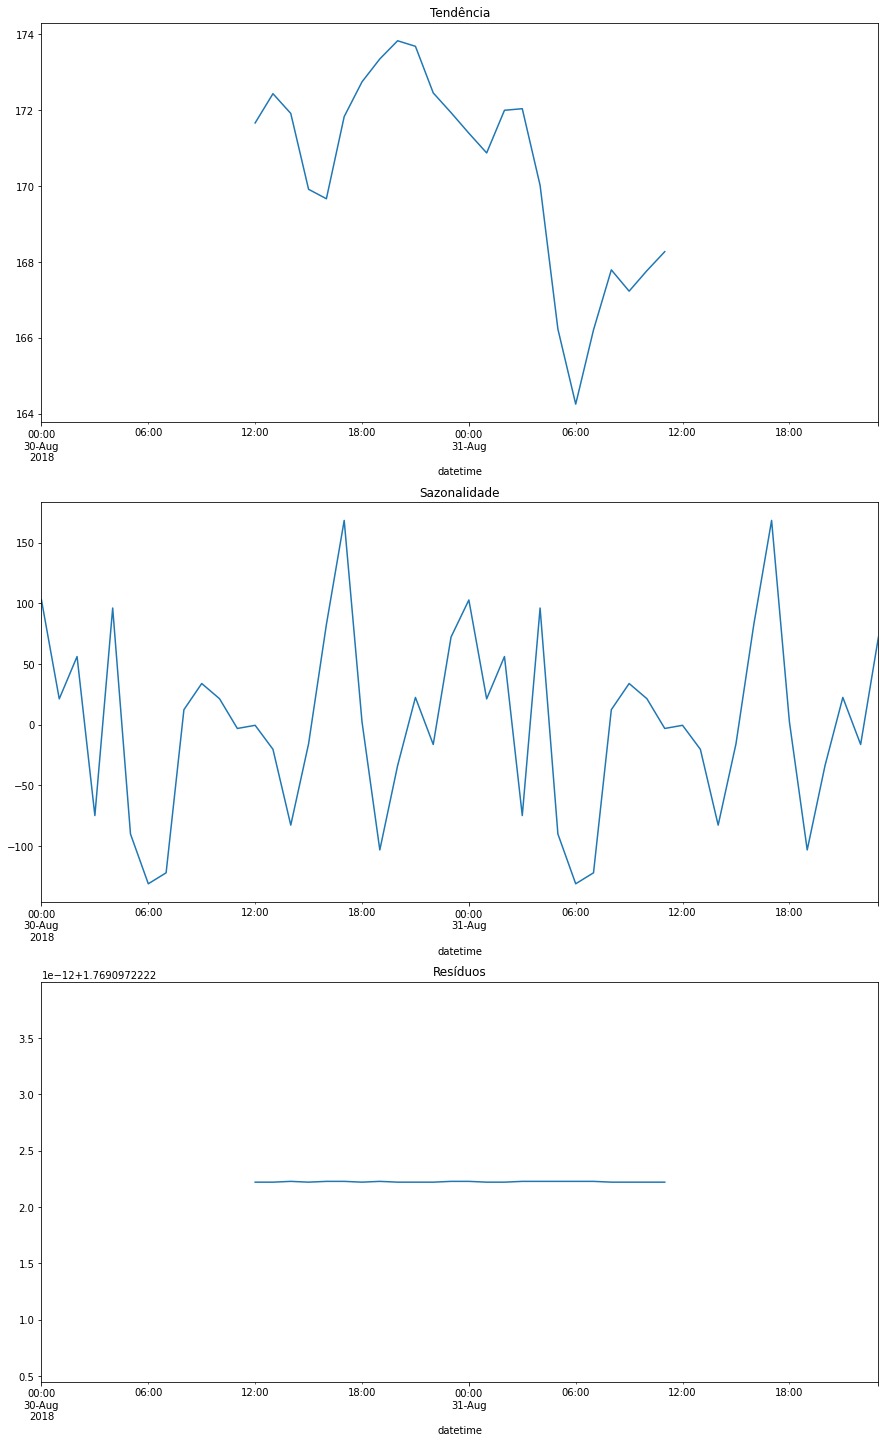

In [12]:
decomposed = seasonal_decompose(data_h.loc['2018-08-30':, :])

plt.figure(figsize=(15, 25))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendência')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Resíduos')

Os gráficos de tendência e sazonalidade confirmam o padrão que definimos anteriormente. Não havia dados suficientes para resíduos. Vamos plotar com a média móvel e o desvio padrão móvel

<AxesSubplot:xlabel='datetime'>

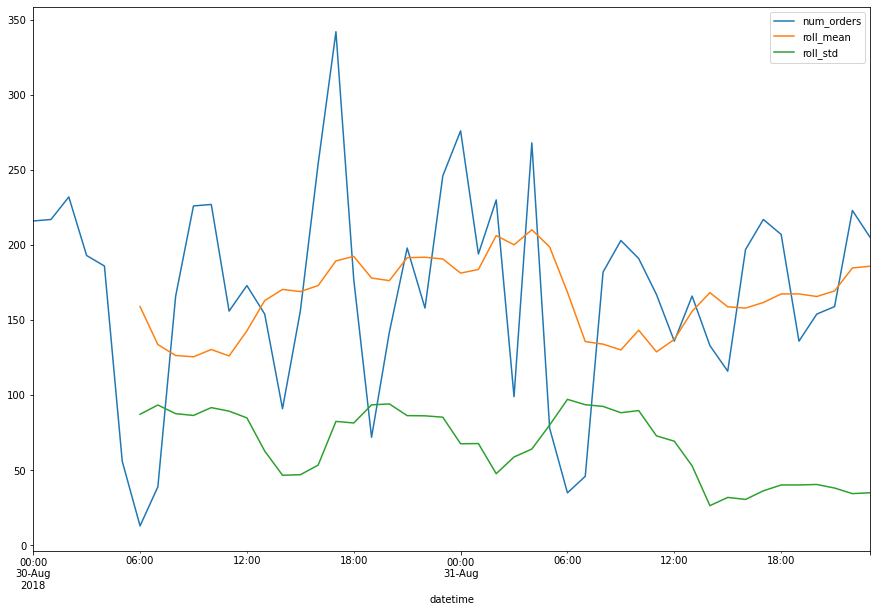

In [13]:
data_spec_d = data_h.loc['2018-08-30':, :].resample('1H').sum()
data_spec_d['roll_mean'] = data_spec_d['num_orders'].rolling(7).mean()
data_spec_d['roll_std'] = data_spec_d['num_orders'].rolling(7).std()
data_spec_d.plot(figsize=(15, 10))

Com base nos gráficos acima, podemos concluir que o sábado é o dia com o maior número de pedidos. Além disso, identificamos que o horário de pico para solicitações de táxi ocorre entre às 18:00 e às 6:00 horas.

# Treinamento de Modelos <a name='3'></a>

Inicialmente, é necessário criar recursos de calendário, como mês, dia, dia da semana e hora, juntamente com recursos de média móvel e atraso (um total de sete) para o objetivo, `num_orders`.

In [14]:
def make_features(data, max_lag, roll_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['roll_mean'] = data['num_orders'].shift().rolling(roll_mean_size).mean()

make_features(data_h, 7, 24)

data_h.dropna(inplace=True)
data_h.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,roll_mean
datetime,,,,,,,,,,,,,
2018-03-02 00:00:00,90,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.833333
2018-03-02 01:00:00,120,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,55.416667
2018-03-02 02:00:00,75,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,57.041667
2018-03-02 04:00:00,20,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,56.958333


Criando as características e objetivos:

In [15]:
f = data_h.drop(['num_orders'], axis=1)
t = data_h['num_orders']

Procederemos com a divisão dos dados. Para evitar embaralhamento, definiremos `shuffle=False` e não utilizaremos nenhum valor para `random_state`, uma vez que estamos realizando previsões baseadas na progressão do tempo.

In [16]:
f_train, f_test, t_train, t_test = train_test_split(f, t, shuffle=False, test_size=0.1)

print(f_train.shape)
print(t_train.shape)
print(f_test.shape)
print(t_test.shape)

(3952, 12)
(3952,)
(440, 12)
(440,)


Agora criaremos um conjunto separado que terá one-hot encoding (OHE) para as características de mês, dia, dia da semana e hora. Não utilizaremos esses dados nos modelos de árvore.

In [17]:
data_h_ohe = pd.get_dummies(data=data_h, columns=['month', 'day', 'dayofweek', 'hour'], drop_first=True)

f_ohe = data_h_ohe.drop(['num_orders'], axis=1)
t_ohe = data_h_ohe['num_orders']
f_train_ohe, f_test_ohe, t_train_ohe, t_test_ohe = train_test_split(f_ohe, t_ohe, shuffle=False, test_size=0.1)
print(f_train_ohe.shape)
print(t_train_ohe.shape)
print(f_test_ohe.shape)
print(t_test_ohe.shape)

(3952, 72)
(3952,)
(440, 72)
(440,)


Criando a função RMSE

In [18]:
def rmse(targ, pred):
    pred = np.array(pred)
    targ = np.array(targ)
    error = pred-targ
    sq_error = error**2
    msq_error = sq_error.mean()
    score = msq_error**0.5
    return score
scorer = make_scorer(rmse, greater_is_better=False)

## Linear Regression <a name='31'></a>

Validação cruzada do modelo:

In [19]:
lr = LinearRegression()
lr_score = cross_val_score(lr, f_train, t_train, scoring=scorer, cv=3)
print(lr_score.mean())

-30.803849777548265


Agora podemos treinar, testar e obter o RMSE

In [20]:
lr = LinearRegression()
lr.fit(f_train, t_train)
lr_pred = lr.predict(f_test)
lr_rmse = rmse(t_test, lr_pred)
lr_rmse

51.31242058840531

Repetindo o processo acima com os conjuntos codificados

In [21]:
lr_ohe = LinearRegression()
lr_ohe.fit(f_train_ohe, t_train_ohe)
lr_ohe_pred = lr_ohe.predict(f_test_ohe)
lr_ohe_rmse = rmse(t_test_ohe, lr_ohe_pred)
lr_ohe_rmse

45.33827575859189

Observamos que a codificação melhorou a qualidade do modelo de regressão linear

## Decision Tree <a name='32'></a>

Realizaremos o ajuste de hiperparâmetros (usando o hiperparâmetro max_depth) e obteremos as pontuações da validação cruzada. Em seguida, treinaremos o modelo com o hiperparâmetro que resultar na melhor pontuação.

In [22]:
for depth in range(1, 10):
    dtr = DecisionTreeRegressor(max_depth=depth, random_state=random_state)
    dtr_score = cross_val_score(dtr, f_train, t_train, scoring=scorer, cv=3)
    print('Max depth=', depth, ':', dtr_score.mean())

Max depth= 1 : -36.939625098103456
Max depth= 2 : -35.5945580529301
Max depth= 3 : -32.833954741934114
Max depth= 4 : -31.134752835448367
Max depth= 5 : -31.04995476262515
Max depth= 6 : -30.8222110779537
Max depth= 7 : -30.189436656929598
Max depth= 8 : -30.875845035145158
Max depth= 9 : -31.54169537149693


Obtendo o RMSE:

In [23]:
dtr = DecisionTreeRegressor(max_depth=7, random_state=random_state)
dtr.fit(f_train, t_train)
dtr_pred = dtr.predict(f_test)
dtr_rmse = rmse(t_test, dtr_pred)
dtr_rmse

56.52130613499048

O desempenho foi pior do que o modelo fraco de regressão linear

## Random Forest <a name='33'></a>

Foi realizado o ajuste de hiperparâmetros com max_depth e n_estimators, e a melhor pontuação de validação cruzada foi alcançada com `n_estimators=40` e `max_depth=10`.

In [24]:
for depth in range(1, 11):
    rfr = RandomForestRegressor(n_estimators=40, max_depth=depth, random_state=random_state)
    rfr_score = cross_val_score(rfr, f_train, t_train, scoring=scorer, cv=3)
    print('Max depth=', depth, ':', rfr_score.mean())

Max depth= 1 : -36.556179279540096
Max depth= 2 : -34.58258358299548
Max depth= 3 : -31.847614013399156
Max depth= 4 : -29.946342258584934
Max depth= 5 : -28.747175811169466
Max depth= 6 : -28.06688961370705
Max depth= 7 : -27.3563905843413
Max depth= 8 : -26.864976802540184
Max depth= 9 : -26.485259678406106
Max depth= 10 : -26.30383320619445


Obtendo o RMSE com os parâmetros citados.

In [25]:
rfr = RandomForestRegressor(n_estimators=40, max_depth=10, random_state=random_state)
rfr.fit(f_train, t_train)
rfr_pred = rfr.predict(f_test)
rfr_rmse = rmse(t_test, dtr_pred)
rfr_rmse

56.52130613499048

## CatBoost Regressor <a name='34'></a>

Primeiro faremos o ajuste de hiperparâmetros com `GridSearchCV` para obter os melhores parâmetros para treinar o modelo

In [26]:
model = CatBoostRegressor()
parameters = {'depth':[6, 8, 10],
              'learning_rate':[0.5, 0.1],
              'l2_leaf_reg':[2, 4],
              'iterations':[10, 50],
              'loss_function':['RMSE'],
              'random_seed':[random_state]}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train, t_train)
best_param = grid.best_params_

0:	learn: 31.7174156	total: 48.9ms	remaining: 440ms
1:	learn: 28.0570048	total: 51.6ms	remaining: 207ms
2:	learn: 26.1466266	total: 54ms	remaining: 126ms
3:	learn: 25.6360465	total: 56.4ms	remaining: 84.6ms
4:	learn: 24.8245250	total: 58.9ms	remaining: 58.9ms
5:	learn: 24.5219412	total: 61.2ms	remaining: 40.8ms
6:	learn: 23.7663322	total: 63.5ms	remaining: 27.2ms
7:	learn: 23.6141492	total: 65.8ms	remaining: 16.5ms
8:	learn: 23.3554024	total: 68.1ms	remaining: 7.57ms
9:	learn: 23.1728319	total: 70.4ms	remaining: 0us
0:	learn: 31.0578524	total: 2.58ms	remaining: 23.2ms
1:	learn: 27.7344143	total: 5.58ms	remaining: 22.3ms
2:	learn: 25.9166019	total: 8.39ms	remaining: 19.6ms
3:	learn: 24.5959717	total: 10.8ms	remaining: 16.2ms
4:	learn: 23.9327995	total: 13.5ms	remaining: 13.5ms
5:	learn: 23.4000063	total: 15.8ms	remaining: 10.6ms
6:	learn: 23.1138151	total: 18.3ms	remaining: 7.84ms
7:	learn: 22.9880304	total: 21ms	remaining: 5.25ms
8:	learn: 22.4108510	total: 23.4ms	remaining: 2.59ms
9:	

Melhores parâmetros:

In [27]:
print('Melhor pontuação dos parâmetros pesquisados:', grid.best_score_)
print('Melhores parâmetros:', best_param)

Melhor pontuação dos parâmetros pesquisados: -26.30757937440923
Melhores parâmetros: {'depth': 6, 'iterations': 50, 'l2_leaf_reg': 2, 'learning_rate': 0.1, 'loss_function': 'RMSE', 'random_seed': 12345}


Obtendo o RMSE com os parâmetros acima.

In [28]:
cbr = CatBoostRegressor(iterations=best_param['iterations'],
                        depth=best_param['depth'],
                        learning_rate=best_param['learning_rate'],
                        l2_leaf_reg=best_param['l2_leaf_reg'],
                        loss_function='RMSE',
                        random_seed=random_state)
cbr.fit(f_train, t_train, verbose=False, plot=False)
cbr_pred = cbr.predict(f_test)
cbr_rmse = rmse(t_test, cbr_pred)
cbr_rmse

49.807661528812126

Repetindo com o OHE

In [29]:
model = CatBoostRegressor()
parameters = {'depth':[6, 8, 10],
              'learning_rate':[0.5, 0.1],
              'l2_leaf_reg':[2, 4],
              'iterations':[10, 50],
              'loss_function':['RMSE'],
              'random_seed':[random_state]}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train_ohe, t_train_ohe)
best_param = grid.best_params_

0:	learn: 33.8376353	total: 33.1ms	remaining: 298ms
1:	learn: 30.7023396	total: 37.4ms	remaining: 150ms
2:	learn: 29.3394738	total: 41.7ms	remaining: 97.2ms
3:	learn: 28.0149112	total: 45.9ms	remaining: 68.9ms
4:	learn: 27.2916325	total: 50.2ms	remaining: 50.2ms
5:	learn: 26.6495211	total: 54.5ms	remaining: 36.3ms
6:	learn: 26.3041756	total: 58.6ms	remaining: 25.1ms
7:	learn: 25.7921805	total: 62.8ms	remaining: 15.7ms
8:	learn: 25.5638004	total: 67.1ms	remaining: 7.46ms
9:	learn: 25.1699395	total: 71.2ms	remaining: 0us
0:	learn: 34.2062383	total: 2.66ms	remaining: 24ms
1:	learn: 30.0148037	total: 5.7ms	remaining: 22.8ms
2:	learn: 28.3887223	total: 8.91ms	remaining: 20.8ms
3:	learn: 27.4820178	total: 11.5ms	remaining: 17.2ms
4:	learn: 26.7324979	total: 14.1ms	remaining: 14.1ms
5:	learn: 26.4794760	total: 42ms	remaining: 28ms
6:	learn: 25.8313859	total: 44.8ms	remaining: 19.2ms
7:	learn: 25.3743426	total: 47.5ms	remaining: 11.9ms
8:	learn: 25.1267922	total: 50.1ms	remaining: 5.57ms
9:	le

In [30]:
print('Melhor pontuação dos parâmetros pesquisados:', grid.best_score_)
print('Melhores parâmetros:', best_param)

Melhor pontuação dos parâmetros pesquisados: -28.25236324454791
Melhores parâmetros: {'depth': 6, 'iterations': 50, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'loss_function': 'RMSE', 'random_seed': 12345}


A função de validação cruzada sempre negativará o valor de uma métrica que deve ser minimizada. Portanto, a pontuação retornada é negativa quando se trata de uma métrica a ser minimizada e positiva quando é uma métrica a ser maximizada. Ao definir o marcador, estabelecemos `greater_is_better=False`, pois estamos buscando minimizá-lo.

In [31]:
cbr_ohe = CatBoostRegressor(iterations=best_param['iterations'],
                           depth=best_param['depth'],
                           learning_rate=best_param['learning_rate'],
                           l2_leaf_reg=best_param['l2_leaf_reg'],
                           loss_function='RMSE',
                           random_seed=random_state)
cbr.fit(f_train_ohe, t_train_ohe, verbose=False, plot=False)
cbr_ohe_pred = cbr.predict(f_test_ohe)
cbr_ohe_rmse = rmse(t_test_ohe, cbr_ohe_pred)
cbr_ohe_rmse

46.94252228207107

## Light GBM <a name='35'></a>

Como acima, realizaremos o ajuste de hiperparâmetros:

In [32]:
model = LGBMRegressor()
parameters = {'num_leaves':[10, 20, 30],
              'learning_rate':[0.5, 0.1],
              'n_estimators':[10, 20],
              'objective':['rmse'],
              'random_state':[random_state]}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train, t_train)
best_param = grid.best_params_

In [33]:
print('Melhor pontuação dos parâmetros pesquisados:', grid.best_score_)
print('Melhores parâmetros:', best_param)

Melhor pontuação dos parâmetros pesquisados: -25.512289275374602
Melhores parâmetros: {'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'objective': 'rmse', 'random_state': 12345}


Obtendo o RMSE

In [34]:
lgbm = LGBMRegressor(num_leaves=best_param['num_leaves'],
                    learning_rate=best_param['learning_rate'],
                    n_estimators=best_param['n_estimators'],
                    objective='rmse',
                    random_state=random_state)
lgbm.fit(f_train, t_train)
lgbm_pred = lgbm.predict(f_test)
lgbm_rmse = rmse(t_test, lgbm_pred)
lgbm_rmse

44.412265827226854

Repetindo com os dados codificados

In [35]:
model = LGBMRegressor()
parameters = {'num_leaves':[10, 20, 30],
              'learning_rate':[0.5, 0.1],
              'n_estimators':[10, 20],
              'objective':['rmse'],
              'random_state':[random_state]}
grid = GridSearchCV(estimator=model, param_grid=parameters, scoring=scorer, cv=3, n_jobs=-1, verbose=0)
grid.fit(f_train_ohe, t_train_ohe)
best_param = grid.best_params_

In [36]:
print('Melhor pontuação dos parâmetros pesquisados:', grid.best_score_)
print('Melhores parâmetros:', best_param)

Melhor pontuação dos parâmetros pesquisados: -28.155622540610555
Melhores parâmetros: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 10, 'objective': 'rmse', 'random_state': 12345}


In [37]:
lgbm_ohe = LGBMRegressor(num_leaves=best_param['num_leaves'],
                        learning_rate=best_param['learning_rate'],
                        n_estimators=best_param['n_estimators'],
                        objective='rmse',
                        random_state=random_state)
lgbm_ohe.fit(f_train_ohe, t_train_ohe)
lgbm_ohe_pred = lgbm_ohe.predict(f_test_ohe)
lgbm_ohe_rmse = rmse(t_test_ohe, lgbm_ohe_pred)
lgbm_ohe_rmse

45.667082220000744

# Conclusão <a name='4'></a>

Realizamos uma análise dos dados da série temporal e identificamos que o dia de pico para viagens de táxi era aos sábados, enquanto o horário de pico ocorria entre 18h e 6h.

In [38]:
summary = pd.DataFrame(index=['LR', 'LR_ohe', 'DTR', 'RFR', 'CBR', 'CBR_ohe', 'LGBM', 'LGBM_ohe'],
                       data={'RMSE':[lr_rmse, lr_ohe_rmse, dtr_rmse, rfr_rmse, cbr_rmse, cbr_ohe_rmse,
                                     lgbm_rmse, lgbm_ohe_rmse]})
summary

,RMSE
LR,51.312421
LR_ohe,45.338276
DTR,56.521306
RFR,56.521306
CBR,49.807662
CBR_ohe,46.942522
LGBM,44.412266
LGBM_ohe,45.667082


Pela tabela acima vemos que o modelo LGBM tem a melhor raiz de erro quadrático médio. Portanto, esse será o modelo de recomendação.